In [47]:
import sympy as sp
import numpy as np
import matplotlib.pyplot as plt
import json
import pandas as pd
import os

import yaml
import hashlib

In [30]:
from sympy import init_printing
init_printing() 


In [48]:
class SymbolicDiscreteDamage:
    def __init__(self, matpar, 
                 name = "discrete generalised damage",
                 slug = "general damage"):
        # self.state = state

        self.state = self._state(matpar)
        self.matpar = matpar
        self.sympar = {str(key): sp.symbols(str(key)) for key in matpar.keys()}
        self.str = name
        self.slug = slug

    def _state(self, matpar):

        _N = matpar["N"]
        
        u = sp.symbols([f"u{i}" for i in range(0, _N)])
        e = sp.symbols([f"e{i}" for i in range(1, _N+1)])
        α = sp.symbols([f"α{i}" for i in range(1, _N+1)])

        return {"u": u, "α": α, "e": e}

    def _s(self, αi):
        s = sp.Function('s')
        # s = 1/self._a(αi)
        return s(αi)

    def _a(self, αi):
        γ = self.matpar["γ"]
        a = sp.Function('a')
        return a(αi)
    
    def energy(self, state):
        """Total energy"""
        return self._elastic(state) + self._damage(state) - self.work(state)

    def work(self, state):
        return 0

    def _elastic(self, state):
        e = state["e"]
        α = state["α"]
        _E0 = self.sympar["E0"]
        _N = self.sympar["N"]
    
        return 1/_N * sum([1./2. * _E0 * self._a(α[i]) * e[i]**2 for i in range(len(α))])

    def _w(self, αi):
        w = sp.Function('w')

        return w(αi)

    def _damage(self, state):
        _α = state["α"]
        _w1 = self.matpar["w1"]

        _N = self.matpar["N"]

        return 1/_N * sum([_w1 * self._w(_α[i]) for i in range(len(_α))])
        # return _w1 * self._w(_α)


    # Explicit expressions
    def w(self, αi):
        return αi

    def boundary_condition(self):
        t = sp.symbols('t')
        N = sp.symbols("N")
        L = sp.symbols("L")
        
        return t*N/L       

    def a(self, αi):
        γ = self.matpar["γ"]

        return (1 - self._w(αi)) / ((γ-1) * self._w(αi) + 1)

    def s(self, αi):

        return 1. / self.a(αi)


    def __str__(self):
     return self.str


In [83]:
class ModelAnalysis:
    """Helper class to analyse (stability) properties of a model"""

    def __init__(self, model):
        self.model = model
        self.state = model.state
        _state = self.state
        self.matpar = model.matpar

        _β = sp.symbols('β')
        _e = sp.symbols('e')
        self._β = _β
        self._e = _e
        
        self._s = model._s(_β)
        self._sp = sp.diff(self._s, _β, 1)
        self._spp = sp.diff(self._s, _β, 2)

        self._a = model._a(_β)
        self._ap = sp.diff(self._a, _β, 1)
        self._app = sp.diff(self._a, _β, 2)

        self._w = model._w(_β)
        self._wp = sp.diff(self._w, _β)
        self._wpp = sp.diff(self._w, _β, 2)

        self.criterion()

    def _equilirbrium_e(self):
        state = self.state
        t, L, N =  sp.symbols('t L N')
        _S = sum([self.model._s(αi) for αi in state["α"]])

        datum = self.model.boundary_condition()
        
        _e = [(datum * self.model._s(αi) / _S).simplify() \
                    for αi in state["α"]]

        return _e
    
    def _elastic_energy_fc_alpha(self):
        _ei = self._equilirbrium_e()
        state = self.state
        equilibrium_subs = {v[0]: v[1] for v in zip(state["e"], _ei)}
        subs_s_inverse = {sp.Function('a')(sp.Symbol(a.name)): 1/self.model._s(a) for a in state["α"]}

        return self.model._elastic(state).subs(equilibrium_subs).subs(subs_s_inverse).simplify()

    def _state_split(self, m, state, matpar):
        """Split the state into homogeneous and bifurcated parts"""

        assert m < matpar[N]

        _bif_α = [state["α"][k+1] for k in range(m)]
        _bif_e = [state["e"][k+1] for k in range(m)]

        _homo_α = set(state["α"]) - set(_bif_α)
        _homo_e = set(state["e"]) - set(_bif_e)

        return _bif_α, _homo_α, _bif_e, _homo_e

    def _state_homog_substitutions(self):
        """Substitutions for the homogeneous state"""
        αt = sp.symbols('α_t')
        et = sp.symbols('e_t')
        state = self.model.state
        _subs_αh = {a: αt for a in state["α"]}
        _subs_eh = {e: et for e in state["e"]}

        return _subs_αh, _subs_eh

    def _state_bifurcation_substitutions(self, m, state, matpar):
        """Computes substitutions for bifurcated states"""

        assert m < matpar[N]
        _bif, _homo, _bif_e, _homo_e = self._state_split(m, state, matpar)
        _αb = sp.symbols('α_t')
        _eb = sp.symbols('e_t')
        αt = sp.symbols("α^*")
        et = sp.symbols("e^*")

        _subs_αb = {a: _αb for a in _bif}
        _subs_eb = {e: _eb for e in _bif_e}

        _subs_αt = {a: αt for a in _homo}
        _subs_et = {e: et for e in _homo_e}

        return {**_subs_αb, **_subs_αt}, {**_subs_eb, **_subs_et}
    
    def criterion(self):
        """Damage onset"""
        model, state = self.model, self.state
        x = sp.symbols('x')
        t, L, N =  sp.symbols('t L N')

        β = self._β
        e = self._e

        # _u0 = t*x/L
        _e0 = t/L
        _α0 = 0

        _homogeneous_damage = {a: β for a in state["α"]}
        _homogeneous_strain = {ε: e for ε in state["e"]}

        _crit = sp.diff(
            model.energy(state)                 \
                .subs(_homogeneous_damage)      \
                .subs(_homogeneous_strain), β)  \
                .subs({e: _e0, β: _α0})    

        self.crit = 1/N * _crit

        return self.crit.simplify()

    def critical_load(self, matpar = {}):
        """Critical load"""
        _a = sp.Function('a')
        _w = sp.Function('w')
        t = sp.symbols('t')

        criterion = self.crit           \
            .replace(_a, self.model.a)  \
            .replace(_w, self.model.w)

        tc = sp.solve(criterion, t)
        
        if matpar:
            tc = [_tc.subs(matpar) for _tc in tc if _tc.subs(matpar).is_positive]
        
        return tc, criterion

    def energy_fc_alpha(self):
        _ei = self._equilirbrium_e()
        state = self.state
        equilibrium_subs = {v[0]: v[1] for v in zip(state["e"], _ei)}
        subs_s_inverse = {sp.Function('a')(sp.Symbol(a.name)): 1/self.model._s(a) for a in state["α"]}

        return self.model.energy(state).subs(equilibrium_subs).subs(subs_s_inverse).simplify()

    def homogeneous_α(self, state, matpar = {}):
        """Solves the (homogeneous) evolution law for damage"""
        αt = sp.symbols('α_t')
        state = self.state
        
        if matpar:
            return [sol.subs(matpar) for sol in \
                    list(map(sp.simplify, sp.solve(self.evo_α(state, matpar), αt)))]
        else:
            return list(map(sp.simplify, sp.solve(self.evo_α(state), αt)))

    def homogeneous_damage(self, state, matpar= {}):
        idx = self.positive_solution_wrt_t(matpar)
        _alpha = self.homogeneous_α(matpar)[idx].subs(matpar)
        tc = self.critical_load(matpar)[0][0]
        t = sp.symbols('t')

        # tc = self.critical_load(matpar)
        alpha = sp.Piecewise(
            (_alpha, t >= tc),
            (0, t < tc)
        )

        return alpha
    #     stress_alpha = sp.Piecewise(
        # (sp.sqrt(2 * self._wp / self._sp).subs({α: _ah}), t >= _tc),
        # (sp.diff(_u0, x).subs(_matpar), t < _tc))

    def evo_α(self, state, matpar = {}):
        """Evolution law for damage"""
        αt = sp.symbols('α_t')
        _a = sp.Function('a')
        _w = sp.Function('w')

        subs_homog_α, _ =  self._state_homog_substitutions()

        energy = self.energy_fc_alpha()               \
            .subs(subs_homog_α)                       \
            .replace(sp.Function('s'), self.model.s)  \
            .replace(_w, self.model.w)                \
            .doit()
        
        if matpar:
            energy = energy.subs(matpar)
            
        return sp.diff(energy, αt).simplify()

    def positive_solution_wrt_t(self, _matpar = {}):
        idx = np.where(np.array([sp.diff(eq, sp.symbols('t')).subs(_matpar) for eq in self.homogeneous_α(_matpar)]) > 0)[0]
        return idx[0]

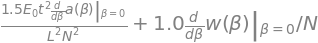

In [50]:
# N = sp.symbols("N")
# t = sp.symbols('t')
_a = sp.Function('a')
_w = sp.Function('w')

_N = 3

# γ = sp.symbols('γ')
# E0, L, w1, σc = sp.symbols('E0 L w1 σc')

# u = sp.symbols([f"u{i}" for i in range(0, _N)])
# e = sp.symbols([f"e{i}" for i in range(1, _N+1)])
# α = sp.symbols([f"α{i}" for i in range(1, _N+1)])

_α = sp.symbols("α")
β = sp.symbols('β')

# state = {"u": u, "α": α, "e": e}
_matpar = {"N": 3, "γ": 2, "E0": 1, "w1": 1, "L": 1}
# matpar = {"N": N, "γ": γ, "E0": E0, "w1": w1, "L": L}

atls = SymbolicDiscreteDamage(_matpar)

system = ModelAnalysis(atls)
system.criterion()


In [29]:
sp.latex(_)

'\\frac{1.5 E_{0} t^{2} \\left. \\frac{d}{d β} a{\\left(β \\right)} \\right|_{\\substack{ β=0 }}}{L^{2} N^{2}} + \\frac{1.0 \\left. \\frac{d}{d β} w{\\left(β \\right)} \\right|_{\\substack{ β=0 }}}{N}'

In [51]:
atls.state

{'u': [u0, u1, u2], 'α': [α1, α2, α3], 'e': [e1, e2, e3]}

In [52]:
atls._elastic(system.state)

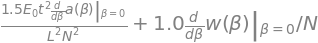

In [53]:
system.criterion().simplify()

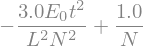

In [54]:
(system.criterion()  \
    .replace(_a, system.model.a )    \
    .replace(_w, system.model.w).doit()).simplify()

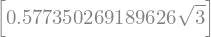

In [55]:
tc, criterion = system.critical_load(_matpar)
tc

In [56]:
system._state_homog_substitutions()

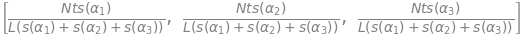

In [57]:
system._equilirbrium_e()

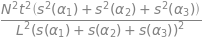

In [58]:
sum([e**2 for e in system._equilirbrium_e()]).simplify()

In [59]:
np.sum([e.subs({a: 0 for a in system.state['α']}) for e in system._equilirbrium_e()])

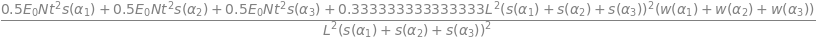

In [60]:
system.energy_fc_alpha().simplify()

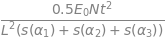

In [61]:
system._elastic_energy_fc_alpha().simplify()

In [62]:
subs_homog_α, subs_homog_e =  system._state_homog_substitutions()
subs_homog_α, subs_homog_e

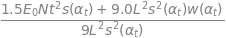

In [63]:
system.energy_fc_alpha().subs(subs_homog_α)

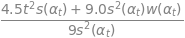

In [64]:
(system.energy_fc_alpha().subs(subs_homog_α)).subs(_matpar)

In [65]:
_a = sp.Function('a')
_w = sp.Function('w')
_s = sp.Function('s')


$$
\begin{aligned}
\mathcal E_N (e, \alpha) &=  E_0\sum_{i=0}^N \frac{1}{2}    a(\alpha_i)  e_i^2  + \sum_{i=0}^N {w_1}w(\alpha_i) \\
{\mathcal E} (u, \alpha) = \frac{\mathcal E_N (e, \alpha)}{N} &=  E_0 N\sum_{i=0}^N \frac{1}{2}  a(\alpha_i)  (u_i-u_{i-1})^2  + \frac{w_1}{N} \sum_{i=0}^N w(\alpha_i) 
\end{aligned}
$$

In [69]:
system.state["α"][0]

In [72]:
# Keeping track of both symboilic and explicit expressions

atls._s(sp.symbols('α')), atls.s(sp.symbols('α'))

In [73]:
atls.energy(system.state).factor()

In [74]:
system.model.energy(system.state)

# _homogeneous_damage = {a: β for a in state["α"]}
# _homogeneous_strain = {e: model._e for e in state["e"]}
# _homogeneous_damage, _homogeneous_strain


In [75]:
_sound = {a: 0 for a in system.state["α"]}
_sound

## Model Analysis

- (constitutive assumptions)
- equilibrium
- homogeneous solution
- homogeneous energy
- bifurcations
- stability

In [84]:
atls = SymbolicDiscreteDamage(_matpar)
system = ModelAnalysis(atls)
(system.criterion()).subs(_matpar)

### homogeneous solution

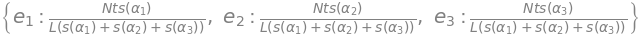

In [85]:
_ei = system._equilirbrium_e()
equilibrium_subs = {v[0]: v[1] for v in zip(system.state["e"], _ei)}

equilibrium_subs

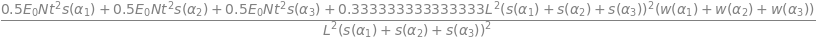

In [86]:
system.energy_fc_alpha() 


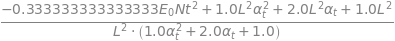

In [87]:
system.evo_α(system.state)

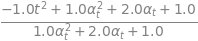

In [88]:
system.evo_α(system.state, _matpar)

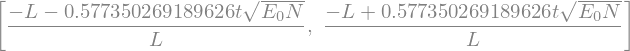

In [89]:
system.homogeneous_α(system.state)

In [90]:
system.homogeneous_α(system.state, _matpar)

In [91]:
idx = system.positive_solution_wrt_t(_matpar)
idx

1

In [92]:
sp.simplify(system.homogeneous_α(_matpar)[idx]).subs(_matpar)

### Homogeneous varying N

<>:43: SyntaxWarning: invalid escape sequence '\d'
<>:43: SyntaxWarning: invalid escape sequence '\d'
/var/folders/ht/z8sb7wsd1bg0qpmyyfyq2rcm0000gr/T/ipykernel_517/2746674941.py:43: SyntaxWarning: invalid escape sequence '\d'
  ax.plot(_loads, _f(_loads), c="k", lw=5, label=f"$\dot \\alpha_N \geq 0, N={_N}$")


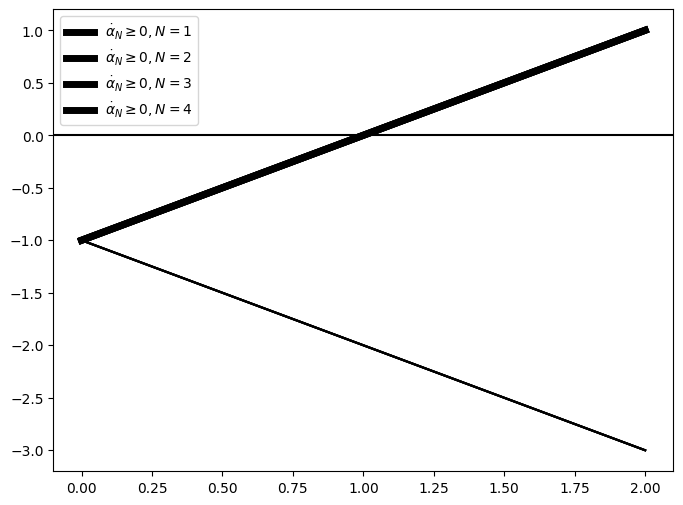

In [97]:
N = sp.symbols("N")
t = sp.symbols("t")
_a = sp.Function("a")
_w = sp.Function("w")
γ = sp.symbols("γ")
E0, L, w1, σc = sp.symbols("E0 L w1 σc")
β = sp.symbols("β")

fig, ax = plt.subplots(1, 1, figsize=(8, 6))

for _N in range(1, 5):
    u = sp.symbols([f"u{i}" for i in range(0, _N)])
    e = sp.symbols([f"e{i}" for i in range(1, _N + 1)])
    α = sp.symbols([f"α{i}" for i in range(1, _N + 1)])
    _α = sp.symbols("α")

    state = {"u": u, "α": α, "e": e}
    _matpar = {"N": _N, "γ": 2, "E0": 1, "w1": 1, "L": 1}
    matpar = {"N": N, "γ": γ, "E0": E0, "w1": w1, "L": L}
    _loads = np.linspace(0.0, float(γ.subs(_matpar)), 30)

    atls = SymbolicDiscreteDamage(_matpar)

    system = ModelAnalysis(atls)
    # print(model.criterion())

    # subs_homog_α, subs_homog_e =  model._state_homog_substitutions(state)

    # Substitutions to compute homogeneous solutions
    # print(subs_homog_α, subs_homog_e)
    # print(model.homogeneous_α(state, _matpar))
    idx = system.positive_solution_wrt_t(_matpar)
    # print(idx)

    evos = [evo.subs(_matpar) for evo in system.homogeneous_α(_matpar)]
    evo_x = evos[idx].subs(_matpar)

    for alphas in evos:
        _f = sp.lambdify(t, alphas.subs(_matpar), "numpy")
        plt.plot(_loads, _f(_loads), c="k")

    _f = sp.lambdify(t, evo_x, "numpy")
    ax.plot(_loads, _f(_loads), c="k", lw=5, label=f"$\dot \\alpha_N \geq 0, N={_N}$")


ax.axhline(0, c="k")
ax.legend()

Text(0.5, 0, 't')

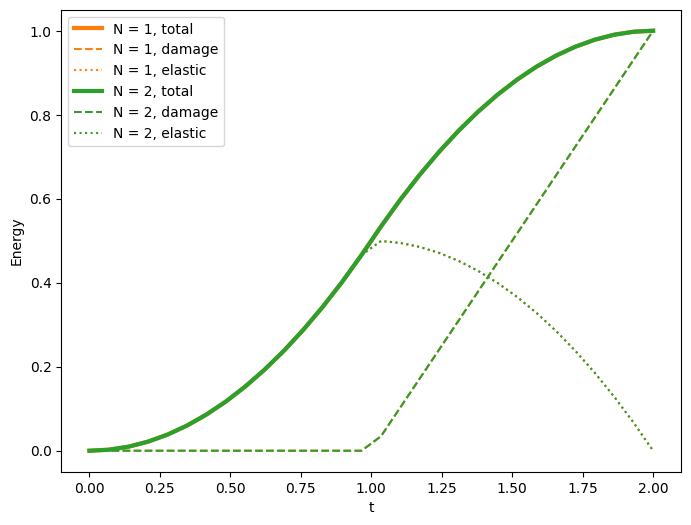

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(8, 6))

for _N in range(1, 3):
    u = sp.symbols([f"u{i}" for i in range(0, _N)])
    e = sp.symbols([f"e{i}" for i in range(1, _N+1)])
    α = sp.symbols([f"α{i}" for i in range(1, _N+1)])
    _α = sp.symbols("α")


    state = {"u": u, "α": α, "e": e}
    _matpar = {N: _N, γ: 2, E0: 1, w1: 1, L: 1}
    matpar = {"N": N, "γ": γ, "E0": E0, "w1": w1, "L": L}
    _loads = np.linspace(0., float(γ.subs(_matpar)), 30)

    atls = SymbolicDiscreteDamage(state, matpar)

    system = ModelAnalysis(atls)

    subs_homog_α, subs_homog_e =  system._state_homog_substitutions(state)
    alpha = system.homogeneous_damage(state, _matpar)

    _en = system.energy_fc_alpha().subs(subs_homog_α)    \
                .subs(_matpar) \
                .replace(_a, system.model.a) \
                .replace(sp.Function('s'), atls.s)      \
                .replace(_w, system.model.w)  \
                .subs(_matpar)          \
        .subs({sp.symbols('α_t'): alpha})

    _energy_damage = system.model._damage(state).subs(subs_homog_α).subs(_matpar) \
                .replace(_w, system.model.w)  \
                .subs({sp.symbols('α_t'): alpha})

    _f = sp.lambdify(t, _en.subs(_matpar), 'numpy')
    _f1 = sp.lambdify(t, _energy_damage, 'numpy')
    ax.plot(_loads, _f(_loads), label=f'N = {_N}, total', lw=3, c=f'C{_N}')
    ax.plot(_loads, _f1(_loads), c=f'C{_N}', label=f'N = {_N}, damage', ls='--')
    ax.plot(_loads, _f(_loads)-_f1(_loads), c=f'C{_N}', label=f'N = {_N}, elastic', ls=":")

ax.legend()
ax.set_ylabel('Energy')
ax.set_xlabel('t')

### Plots of homogeneous response

In [ ]:
subs_homog_α, subs_homog_e =  system._state_homog_substitutions(state)

# Substitutions to compute homogeneous solutions
subs_homog_α, subs_homog_e

({α1: α_t, α2: α_t}, {e1: e_t, e2: e_t})

In [ ]:
evos = [evo.subs(_matpar) for evo in system.homogeneous_α(_matpar)]
evos[idx].subs(_matpar)

0.707106781186548*sqrt(2)*t - 1.0

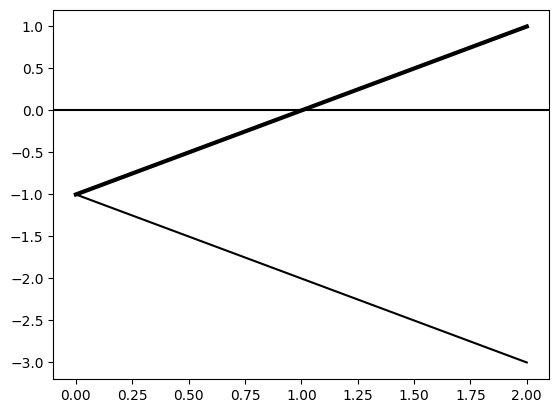

In [ ]:
evos = [evo.subs(_matpar) for evo in system.homogeneous_α(_matpar)]
_loads = np.linspace(0., float(γ.subs(_matpar)), 30)
evo_x = evos[idx].subs(_matpar)

for alphas in evos:
    _f = sp.lambdify(t, alphas.subs(_matpar), 'numpy')
    plt.plot(_loads, _f(_loads), c='k')

_f = sp.lambdify(t, evo_x, 'numpy')
plt.plot(_loads, _f(_loads), c='k', lw=3)


plt.axhline(0, c='k')

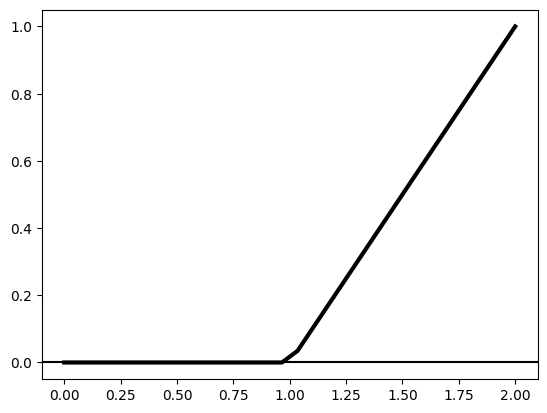

In [ ]:
alpha = system.homogeneous_damage(state, _matpar)

_f = sp.lambdify(t, alpha.subs(_matpar), 'numpy')
plt.plot(_loads, _f(_loads), c='k', lw=3)

plt.axhline(0, c='k')

In [ ]:
_en = system.energy_fc_alpha().subs(subs_homog_α)    \
            .subs(_matpar) \
            .replace(_a, system.model.a) \
            .replace(sp.Function('s'), atls.s)      \
            .replace(_w, system.model.w)  \
            .subs(_matpar)
_en

0.25*(1 - α_t)*(2.0*t**2 + 4.0*α_t*(α_t + 1)/(1 - α_t))/(α_t + 1)

Text(0.5, 0, 't')

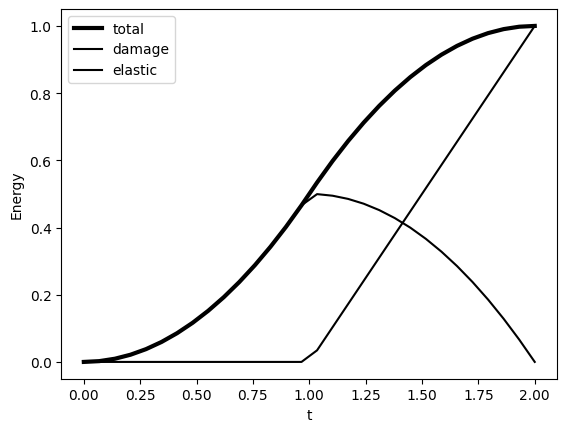

In [ ]:
_en = system.energy_fc_alpha().subs(subs_homog_α)    \
            .subs(_matpar) \
            .replace(_a, system.model.a) \
            .replace(sp.Function('s'), atls.s)      \
            .replace(_w, system.model.w)  \
            .subs(_matpar)          \
    .subs({sp.symbols('α_t'): alpha})

_energy_damage = system.model._damage(state).subs(subs_homog_α).subs(_matpar) \
            .replace(_w, system.model.w)  \
            .subs({sp.symbols('α_t'): alpha})

_f = sp.lambdify(t, _en.subs(_matpar), 'numpy')
_f1 = sp.lambdify(t, _energy_damage, 'numpy')
plt.plot(_loads, _f(_loads), c='k', label='total', lw=3)
plt.plot(_loads, _f1(_loads), c='k', label='damage')
plt.plot(_loads, _f(_loads)-_f1(_loads), c='k', label='elastic')

plt.legend()
plt.ylabel('Energy')
plt.xlabel('t')

### Bifurcations

Compute bifurcated solutions with $m$ damaging springs out of the available $N$, with $m<N$

In [ ]:
_N = 3
_matpar = {N: _N, γ: 2, E0: 1, w1: 1, L: 1}


atls = SymbolicDiscreteDamage(state, matpar)


system = ModelAnalysis(atls)
system.criterion().subs(_matpar)

0.111111111111111*t**2*Subs(Derivative(a(β), β), β, 0) + 2*Subs(Derivative(w(β), β), β, 0)/9

In [ ]:
_matpar[N]

3

In [ ]:
# we bifurcate m springs

m = 1

assert m < _matpar[N]

In [ ]:
bif_α, homo_α, bif_e, homo_e = system._state_split(m, state, _matpar)
print(f'set of bifurcated (evolving) springs {bif_α}')
print(f'set of stationary springs {homo_α}')

set of bifurcated (evolving) springs [α2]
set of stationary springs {α1}


In [ ]:
subs_bif_α, subs_bif_e =  system._state_bifurcation_substitutions(m, state, _matpar)

In [ ]:
# substitutions for damage and strain
subs_bif_α, subs_bif_e

({α2: α_t, α1: α^*}, {e2: e_t, e1: e^*})

In [ ]:
system._elastic_energy_fc_alpha()

0.5*E0*N*t**2/(L**2*(s(α1) + s(α2)))

In [ ]:
_elastic_en_bif_alpha = system._elastic_energy_fc_alpha().subs(subs_bif_α)
_elastic_en_bif_alpha

0.5*E0*N*t**2/(L**2*(s(α^*) + s(α_t)))

In [ ]:
sp.diff(_elastic_en_bif_alpha.subs({sp.symbols('α^*'): 0}), sp.symbols('α_t'))

-0.5*E0*N**2*t**2*Derivative(s(α_t), α_t)/(L**2*(2*s(0) + s(α_t))**2)

In [ ]:
def _elastic_energy_m_bifurcations(m, state):
    n = len(state["α"])
    # n = N
    N = sp.symbols('N')
    # _s = model.model.s
    _s = sp.Function('s')
    
    at = sp.symbols('α_t')
    ax = sp.symbols('α^*')
    return 1./2. * E0 * (N * t / L)**2 * 1 / ((N-m)*_s(ax) + m*_s(at))
    

def _diff_energy_m_bifurcations(m, state):
    n = len(state["α"])
    n = N
    # _s = model.model.s
    _s = sp.Function('s')
    
    at = sp.symbols('α_t')
    ax = sp.symbols('α^*')
    return - 1./2. * E0 * (N * t / L)**2 * m * sp.diff(_s(at), at) / ((n-m)*_s(ax) + m*_s(at))**2
    
    
def energy_m_bifurcations(m, state):
    n = len(state["α"])
    at = sp.symbols('α_t')
    ax = sp.symbols('α^*')
    
    return _elastic_energy_m_bifurcations(m, state) +   \
        model.matpar["w1"] * (m * model.model.w(at) + (n-m) * model.model.w(ax))
    
_diff_energy_m_bifurcations(sp.symbols('m'), state)

-0.5*E0*N**2*m*t**2*Derivative(s(α_t), α_t)/(L**2*(m*s(α_t) + (N - m)*s(α^*))**2)

In [ ]:
energy_m_bifurcations(sp.symbols('m'), state)

0.5*E0*N**2*t**2/(L**2*(m*s(α_t) + (N - m)*s(α^*))) + w1*(m*α_t + α^**(2 - m))

In [ ]:
_elastic_energy_m_bifurcations(sp.symbols('m'), state)


0.5*E0*N**2*t**2/(L**2*(m*s(α_t) + (N - m)*s(α^*)))

In [ ]:
sp.diff(_elastic_energy_m_bifurcations(sp.symbols('m'), state), sp.symbols('α_t'))


-0.5*E0*N**2*m*t**2*Derivative(s(α_t), α_t)/(L**2*(m*s(α_t) + (N - m)*s(α^*))**2)

In [ ]:
sp.diff(energy_m_bifurcations(sp.symbols('m'), state), sp.symbols('α_t'))

-0.5*E0*N**2*m*t**2*Derivative(s(α_t), α_t)/(L**2*(m*s(α_t) + (N - m)*s(α^*))**2) + m*w1

In [ ]:
sp.diff(energy_m_bifurcations(sp.symbols('m'), state).subs({sp.symbols('α^*'): 0}), sp.symbols('α_t'))

-0.5*E0*N**2*m*t**2*Derivative(s(α_t), α_t)/(L**2*(m*s(α_t) + (N - m)*s(0))**2) + m*w1

In [ ]:
bif_crit_m = sp.diff(
    energy_m_bifurcations(sp.symbols('m'), state).subs({sp.symbols('α^*'): 0}) \
    , sp.symbols('α_t'))    \
        .replace(sp.Function('s'), atls.s)      \
        .replace(_w, system.model.w)         \
        .simplify()

bif_crit_m

-0.5*E0*N**2*m*t**2*(α_t - 1)**2*(1.0*α_t*γ/(α_t - 1)**2 - 1.0*α_t/(α_t - 1)**2 - 1.0*γ/(α_t - 1) + 1.0/(α_t - 1) + 1.0/(α_t - 1)**2)/(L**2*(-N*α_t + N + m*α_t*γ)**2) + 1.0*m*w1

In [ ]:
sp.solve(bif_crit_m, sp.symbols('α_t'))[1].simplify()

0.5*N*(2.0*L*w1 - 1.4142135623731*t*sqrt(E0*w1*γ))/(L*w1*(N - m*γ))

In [ ]:
bif_crit_m.simplify()

-0.5*E0*N**2*m*t**2*γ/(L**2*(-N*α_t + N + m*α_t*γ)**2) + 1.0*m*w1

In [ ]:
sp.latex(bif_crit_m.simplify())

'- \\frac{0.5 E_{0} N^{2} m t^{2} γ}{L^{2} \\left(- N α_{t} + N + m α_{t} γ\\right)^{2}} + 1.0 m w_{1}'

In [ ]:
bif_crit_m.simplify()

-0.5*E0*N**2*m*t**2*γ/(L**2*(-N*α_t + N + m*α_t*γ)**2) + 1.0*m*w1

In [ ]:
bif_crit_m.args[1].simplify()

-0.5*E0*N**2*m*t**2*γ/(L**2*(-N*α_t + N + m*α_t*γ)**2)

In [ ]:
num, den = sp.fraction(bif_crit_m.args[1].simplify())

In [ ]:
den.factor(sp.symbols('α_t')) 

L**2*(N + α_t*(-N + m*γ))**2

In [ ]:
sp.latex(den.factor(sp.symbols('α_t')) )

'L^{2} \\left(N + α_{t} \\left(- N + m γ\\right)\\right)^{2}'

In [ ]:
# sp.latex(
sp.solve(bif_crit_m, sp.symbols('α_t'))[1].simplify().subs(_matpar)
# )

1.0*(-1.4142135623731*sqrt(2)*t + 2.0)/(2 - 2*m)

In [ ]:
bif_crit_m = sp.diff(
    energy_m_bifurcations(sp.symbols('m'), state).subs({sp.symbols('α^*'): 0}) \
    , sp.symbols('α_t'))    \
        .replace(sp.Function('s'), atls.s)      \
        .replace(_w, system.model.w)         \
        .subs(_matpar).simplify()

bif_crit_m

-0.5*m*t**2*(α_t - 1)**2*(1.0*α_t/(α_t - 1)**2 - 1.0/(α_t - 1) + 1.0/(α_t - 1)**2)/(1.0*m*α_t - α_t + 1)**2 + m

In [ ]:
bif_m_solutions = sp.solve(bif_crit_m, sp.symbols('α_t'))
# bif_m_solutions[1]

bif_m_solutions

[(-t - 1.0)/(m - 1.0), (t - 1.0)/(m - 1.0)]

In [ ]:
(bif_m_solutions[1]).subs(sp.symbols('m'), 1)

zoo*(t - 1.0)

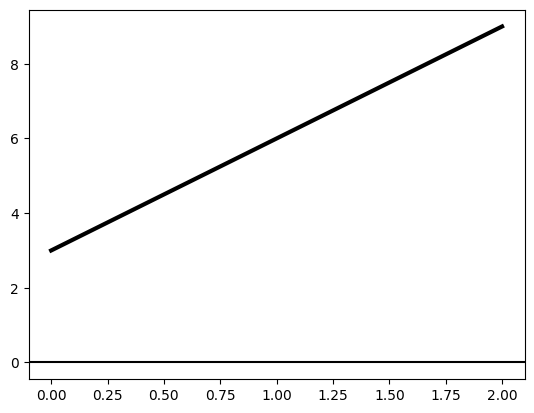

In [ ]:
bif = bif_m_solutions[0].subs(sp.symbols('m'), 1)
_loads = np.linspace(0., float(γ.subs(_matpar)), 30)

_f = sp.lambdify(t, bif.subs(_matpar), 'numpy')
plt.plot(_loads, _f(_loads), c='k', lw=3)

plt.axhline(0, c='k')

1.5*(1.4142135623731*sqrt(2)*t + 2.0)/(3 - 2*m)
1.5*(-1.4142135623731*sqrt(2)*t + 2.0)/(3 - 2*m)
1.5*(1.4142135623731*sqrt(2)*t + 2.0)/(3 - 2*m)
1.5*(-1.4142135623731*sqrt(2)*t + 2.0)/(3 - 2*m)


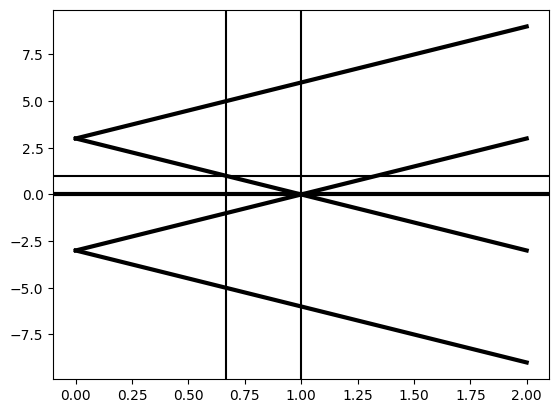

In [ ]:
# sp.latex(
sols = sp.solve(bif_crit_m, sp.symbols('α_t'))
# )
# sols

for _m in range(1, N.subs(_matpar)):
    for sol in sols:
        print(sol.simplify().subs(_matpar))
        _f = sp.lambdify(t, sol.simplify().subs(_matpar).subs(sp.symbols('m'), _m), 'numpy')
        plt.plot(_loads, _f(_loads), c='k', lw=3)
        
plt.axhline(0, c='k', lw=3)
plt.axhline(1, c='k')
plt.axvline(1, c='k')
plt.axvline((γ/N).subs(_matpar), c='k')



In [ ]:
sp.diff(
    _elastic_en_bif_alpha.subs({sp.symbols('α^*'): 0}),
    sp.symbols('α_t')).simplify()   \
    .replace(sp.Function('s'), atls.s)      \
    .replace(_w, model.model.w)                 \
        .subs(_matpar).doit().simplify()  

-0.333333333333333*t**2/(0.037037037037037*α_t**2 - 0.222222222222222*α_t + 0.333333333333333)

In [ ]:
_bif_criterion_m_ela = sp.diff(
    _elastic_en_bif_alpha.subs({sp.symbols('α^*'): 0}),
    sp.symbols('α_t')).simplify()               \
    .replace(sp.Function('s'), atls.s)      \
    .replace(_w, model.model.w)                 \
        .subs(_matpar).doit().simplify()  \
    
_bif_criterion_m_dam = sp.diff(model.model._damage(state).subs(subs_bif_α).subs({sp.symbols('α^*'): 0})    \
    .replace(_w, model.model.w).doit(), sp.symbols('α_t'))


In [ ]:
bif_solutions = sp.solve(_bif_criterion_m_ela + _bif_criterion_m_dam, sp.symbols('α_t'))

In [ ]:
positive_solution_idx = np.where(np.array([sp.diff(b, t).subs(_matpar) for b in bif_solutions]) > 0)[0][0]

In [ ]:
bif_solutions[positive_solution_idx]

3.0*t/sqrt(w1) + 3.0

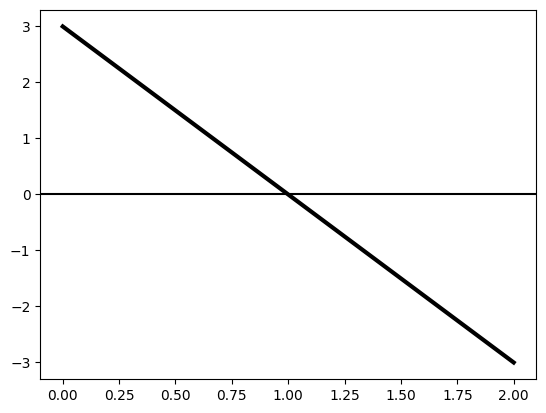

In [ ]:
bif = bif_solutions[0]
_loads = np.linspace(0., float(γ.subs(_matpar)), 30)

_f = sp.lambdify(t, bif.subs(_matpar), 'numpy')
plt.plot(_loads, _f(_loads), c='k', lw=3)

plt.axhline(0, c='k')

In [ ]:
model.model._damage(state).subs(subs_bif_α).subs({sp.symbols('α_t'): 0})   \
            .subs(_matpar) \
            .replace(_w, model.model.w)  \
            .replace(sp.symbols("a^*"), alpha)
            # .subs({sp.symbols('β'): alpha})


Piecewise((0.707106781186548*sqrt(2)*t - 1.0, t >= 0.707106781186548*sqrt(2)), (0, True))

Text(0.5, 0, 't')

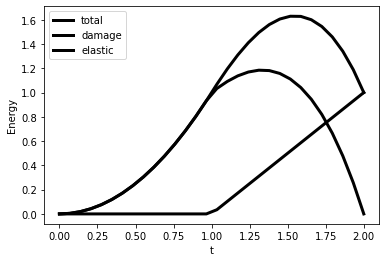

In [ ]:
_en_alpha_bif = model.energy_fc_alpha().subs(subs_bif_α).subs({sp.symbols('α_t'): 0})   \
            .replace(_a, model.model.a) \
            .replace(sp.Function('s'), atls.s)      \
            .replace(_w, model.model.w)  \
            .subs(_matpar)          \
            .replace(sp.symbols("a^*"), alpha)

_energy_damage_bif = model.model._damage(state).subs(subs_bif_α).subs({sp.symbols('α_t'): 0})   \
            .subs(_matpar) \
            .replace(_w, model.model.w)  \
            .replace(sp.symbols("a^*"), alpha)
            # .subs({sp.symbols('β'): alpha})


_f = sp.lambdify(t, _en_alpha_bif, 'numpy')
_fd = sp.lambdify(t, _energy_damage_bif, 'numpy')
plt.plot(_loads, _f(_loads), c='k', label='total', lw=3)
plt.plot(_loads, _fd(_loads), c='k', label='damage', lw=3)
plt.plot(_loads, _f(_loads) - _fd(_loads), c='k', label='elastic', lw=3)

plt.legend()
plt.ylabel('Energy')
plt.xlabel('t')

In [ ]:
# The energy of the bifurcated system

_en_alpha_bifurcations = model.energy_fc_alpha().subs(subs_bif_α).subs({sp.symbols('α_t'): 0})
_en_alpha_bifurcations  \
            .replace(_a, model.model.a) \
            .replace(sp.Function('s'), atls.s)      \
            # .replace(_w, model.model.w)  \
            # .subs(_matpar)          \
            

TypeError: unsupported operand type(s) for /: 'int' and 'method'

In [ ]:
subs_bif_α

{α2: a^*, α1: α_t}

In [ ]:
# The energy of the bifurcated system

_en_alpha_bifurcations = model.energy_fc_alpha().subs(subs_bif_α).subs({sp.symbols('α_t'): 0})
_en_alpha_bifurcations  \
            .replace(_a, model.model.a) \
            .replace(sp.Function('s'), atls.s)      \
            # .replace(_w, model.model.w)  \
            # .subs(_matpar)          \
            

In [ ]:
sp.simplify(_en_alpha_bifurcations) 

(0.5*E0*N**2*t**2*a(0)*s(0)**2 + 0.5*E0*N**2*t**2*a(a^*)*s(a^*)**2 + L**2*w1*(s(0) + s(a^*))**2*(w(0) + w(a^*)))/(L**2*(s(0) + s(a^*))**2)

In [ ]:
sym_en_alpha_bifurcations = sp.simplify(_en_alpha_bifurcations)      \
            .replace(_a, model.model.a)  \
            .replace(sp.Function('s'), atls.s)      \
            .replace(_w, model.model.w)  \
            .subs(_matpar)          \
            .doit()

sym_en_alpha_bifurcations

(a^**(1.0 + 1.0*(a^* + 1)/(1 - a^*))**2 + 2.0*t**2 + 2.0*t**2*(a^* + 1)/(1 - a^*))/(1.0 + 1.0*(a^* + 1)/(1 - a^*))**2

In [ ]:
sum([model.model._s(αi) for αi in state["α"]])      \
            .replace(sp.Function('s'), atls.s)      \
            .replace(_w, model.model.w)  \
            .subs(subs_bif_α)           \
            .subs({sp.symbols('α_t'): 0})

1.0 + 1.0*(a^**(γ - 1) + 1)/(1 - a^*)

<lambdifygenerated-46>:2: RuntimeWarning: divide by zero encountered in true_divide
  return (1.0 + 1.0*(Dummy_1247 + 1)/(1 - Dummy_1247))**2


(1.0, 30.0)

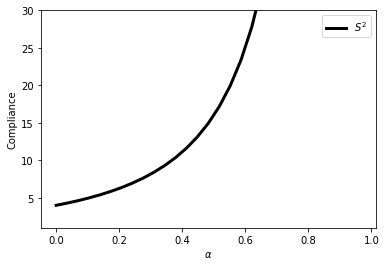

In [ ]:
_compl_alpha = (sum([model.model._s(αi) for αi in state["α"]])**2)      \
            .replace(sp.Function('s'), atls.s)      \
            .replace(_w, model.model.w)  \
            .subs(subs_bif_α)           \
            .subs({sp.symbols('α_t'): 0})   \
            .subs(_matpar)

_f = sp.lambdify(sp.symbols("a^*"), _compl_alpha, 'numpy')
_alphas = np.linspace(0., 1., 30)
plt.plot(_alphas, _f(_alphas), c='k', label='$S^2$', lw=3)

plt.legend()
plt.ylabel(f'Compliance')
plt.xlabel('$\\alpha$')
plt.ylim(1, 30)



(1.0, 30.0)

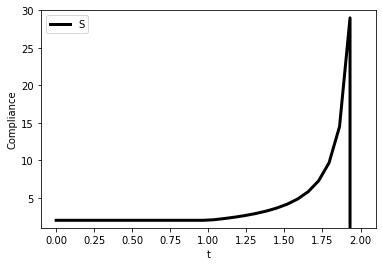

In [ ]:
_S2 = sum([model.model._s(αi) for αi in state["α"]])      \
            .replace(sp.Function('s'), atls.s)      \
            .replace(_w, model.model.w)  \
            .subs(subs_bif_α)           \
            .replace(sp.symbols("a^*"), alpha) \
            .subs({sp.symbols('α_t'): 0})

_f = sp.lambdify(t, _S2.subs(_matpar), 'numpy')
plt.plot(_loads, _f(_loads), c='k', label='S', lw=3)

plt.legend()
plt.ylabel(f'Compliance')
plt.xlabel('t')
plt.ylim(1, 30)

In [ ]:
(model.energy_fc_alpha().subs(subs_bif_α).subs({sp.symbols('α_t'): 0})).subs(_matpar)

2.0*t**2*a(0)*s(0)**2/(s(0) + s(a^*))**2 + 2.0*t**2*a(a^*)*s(a^*)**2/(s(0) + s(a^*))**2 + w(0) + w(a^*)

## Second variation

In [ ]:
model.energy_fc_alpha()

0.5*E0*N**2*t**2*a(α1)*s(α1)**2/(L**2*(s(α1) + s(α2))**2) + 0.5*E0*N**2*t**2*a(α2)*s(α2)**2/(L**2*(s(α1) + s(α2))**2) + w1*w(α1) + w1*w(α2)

In [ ]:
def small_hessian(f_alpha, state):
    n = len(state["α"])
    
    
    return

In [ ]:
small_hess = sp.hessian(model.energy_fc_alpha(), state["α"])

In [ ]:
model.energy_fc_alpha()

0.5*E0*N**2*t**2*a(α1)*s(α1)**2/(L**2*(s(α1) + s(α2))**2) + 0.5*E0*N**2*t**2*a(α2)*s(α2)**2/(L**2*(s(α1) + s(α2))**2) + w1*w(α1) + w1*w(α2)

In [ ]:
state["α"][0].name

'α1'

In [ ]:
subs_inverse = {sp.Function('s')(sp.Symbol(a.name)): 1/_a(a) for a in state["α"]}
subs_inverse


{s(α1): 1/a(α1), s(α2): 1/a(α2)}

In [ ]:
# subs_s_inverse = {sp.Function('s')(sp.Symbol(a.name)): 1/_a(a) for a in state["α"]}
subs_s_inverse = {sp.Function('a')(sp.Symbol(a.name)): 1/model.model._s(a) for a in state["α"]}
subs_s_inverse


{a(α1): 1/s(α1), a(α2): 1/s(α2)}

In [ ]:
model.energy_fc_alpha().subs(subs_inverse)

0.5*E0*N**2*t**2/(L**2*(1/a(α2) + 1/a(α1))**2*a(α2)) + 0.5*E0*N**2*t**2/(L**2*(1/a(α2) + 1/a(α1))**2*a(α1)) + w1*w(α1) + w1*w(α2)

In [ ]:
model.energy_fc_alpha().subs(subs_s_inverse)

0.5*E0*N**2*t**2*s(α1)/(L**2*(s(α1) + s(α2))**2) + 0.5*E0*N**2*t**2*s(α2)/(L**2*(s(α1) + s(α2))**2) + w1*w(α1) + w1*w(α2)

In [ ]:
subs_stiffness = {_a(a): model.model.s(a) for a in state["α"]}
subs_stiffness

{a(α1): 1.0*((γ - 1)*w(α1) + 1)/(1 - w(α1)),
 a(α2): 1.0*((γ - 1)*w(α2) + 1)/(1 - w(α2))}

In [ ]:
small_hess = sp.hessian(model.energy_fc_alpha().subs(subs_s_inverse), state["α"])
small_hess

Matrix([
[0.5*E0*N**2*t**2*Derivative(s(α1), (α1, 2))/(L**2*(s(α1) + s(α2))**2) - 1.0*E0*N**2*t**2*s(α1)*Derivative(s(α1), (α1, 2))/(L**2*(s(α1) + s(α2))**3) - 1.0*E0*N**2*t**2*s(α2)*Derivative(s(α1), (α1, 2))/(L**2*(s(α1) + s(α2))**3) - 2.0*E0*N**2*t**2*Derivative(s(α1), α1)**2/(L**2*(s(α1) + s(α2))**3) + 3.0*E0*N**2*t**2*s(α1)*Derivative(s(α1), α1)**2/(L**2*(s(α1) + s(α2))**4) + 3.0*E0*N**2*t**2*s(α2)*Derivative(s(α1), α1)**2/(L**2*(s(α1) + s(α2))**4) + w1*Derivative(w(α1), (α1, 2)),                                                                                                                                                                                                           -2.0*E0*N**2*t**2*Derivative(s(α1), α1)*Derivative(s(α2), α2)/(L**2*(s(α1) + s(α2))**3) + 3.0*E0*N**2*t**2*s(α1)*Derivative(s(α1), α1)*Derivative(s(α2), α2)/(L**2*(s(α1) + s(α2))**4) + 3.0*E0*N**2*t**2*s(α2)*Derivative(s(α1), α1)*Derivative(s(α2), α2)/(L**2*(s(α1) + s(α2))**4)],
[                          

In [ ]:
model.energy_fc_alpha().subs(subs_s_inverse)

0.5*E0*N**2*t**2*s(α1)/(L**2*(s(α1) + s(α2))**2) + 0.5*E0*N**2*t**2*s(α2)/(L**2*(s(α1) + s(α2))**2) + w1*w(α1) + w1*w(α2)

In [ ]:
small_hess[0, 0]

0.5*E0*N**2*t**2*Derivative(s(α1), (α1, 2))/(L**2*(s(α1) + s(α2))**2) - 1.0*E0*N**2*t**2*s(α1)*Derivative(s(α1), (α1, 2))/(L**2*(s(α1) + s(α2))**3) - 1.0*E0*N**2*t**2*s(α2)*Derivative(s(α1), (α1, 2))/(L**2*(s(α1) + s(α2))**3) - 2.0*E0*N**2*t**2*Derivative(s(α1), α1)**2/(L**2*(s(α1) + s(α2))**3) + 3.0*E0*N**2*t**2*s(α1)*Derivative(s(α1), α1)**2/(L**2*(s(α1) + s(α2))**4) + 3.0*E0*N**2*t**2*s(α2)*Derivative(s(α1), α1)**2/(L**2*(s(α1) + s(α2))**4) + w1*Derivative(w(α1), (α1, 2))

In [ ]:
sp.srepr(model.energy_fc_alpha())

"Add(Mul(Float('0.5', precision=53), Symbol('E0'), Pow(Symbol('L'), Integer(-2)), Pow(Symbol('N'), Integer(2)), Pow(Symbol('t'), Integer(2)), Pow(Add(Function('s')(Symbol('α1')), Function('s')(Symbol('α2'))), Integer(-2)), Function('a')(Symbol('α1')), Pow(Function('s')(Symbol('α1')), Integer(2))), Mul(Float('0.5', precision=53), Symbol('E0'), Pow(Symbol('L'), Integer(-2)), Pow(Symbol('N'), Integer(2)), Pow(Symbol('t'), Integer(2)), Pow(Add(Function('s')(Symbol('α1')), Function('s')(Symbol('α2'))), Integer(-2)), Function('a')(Symbol('α2')), Pow(Function('s')(Symbol('α2')), Integer(2))), Mul(Symbol('w1'), Function('w')(Symbol('α1'))), Mul(Symbol('w1'), Function('w')(Symbol('α2'))))"

In [ ]:
sp.diff(model.energy_fc_alpha().subs(subs_s_inverse), state["α"][0])

0.5*E0*N**2*t**2*Derivative(s(α1), α1)/(L**2*(s(α1) + s(α2))**2) - 1.0*E0*N**2*t**2*s(α1)*Derivative(s(α1), α1)/(L**2*(s(α1) + s(α2))**3) - 1.0*E0*N**2*t**2*s(α2)*Derivative(s(α1), α1)/(L**2*(s(α1) + s(α2))**3) + w1*Derivative(w(α1), α1)

In [ ]:
_i = sp.symbols('i')
sum = sp.summation(_a(_i), (_i, 0, len(state["α"])))
sum

a(0) + a(1) + a(2)

In [ ]:
model.energy_fc_alpha()

TypeError: 'Add' object is not callable